# Team Spray and Pray

<img src="http://media1.giphy.com/media/215lvo8ytxpFC/giphy.gif">

<img src='https://github.com/ga-students/DC-DSI4/blob/master/curriculum/01-week/1.01-welcome/data-science-workflow-final.jpg?raw=true'>

# 1) Identify the Problem


West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, __this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus.__ A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.


Submissions are evaluated on area under the ROC curve between the predicted probability that West Nile Virus is present and the observed outcomes.

Submission File

For each record in the test set, you should __predict a real-valued probability that WNV is present.__ The file should contain a header and have the following format:

    Id,WnvPresent

    1, 0

    2, 1

    3, 0.9

    4, 0.2

    etc.
    
### Strategy

We intend to merge the train, weather and spray data files and review the data where West Nile virus is present.

### Questions

What information do we need in order to predict whether or not a mosquito is + for West Nile virus (WNV)?  _Ex, do we need the spray data, weather data or only the training data?_

What species of mosquitos tested + for WNV?

What was the most common time period for mosquitos with WNV?  _Late spring - fall, per briefing, but let's try to get more specific._

What location has the most mosquitos with WNV?

# 2) Acquire the Data

We are going to start by using three files, train, spray and weather.   We will use the test data to verify which variables we are able to use in model building.

We have downloaded the files from the kaggle website and saved them on a shared git repository that Adi created.  Adi made Troy and I contributors and we forked the repository on our local drives.  

We are going to use python to complete this challenge, more specifically, we will use pandas to read, clean and perform eda.  We will also use numpy and pandas profiling.

In [4]:
# Let's import the libraries we will need at this time
import pandas as pd
import numpy as np
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 3) Parse the Data

##### Data Description

In this competition, you will be analyzing weather data and GIS data and predicting whether or not West Nile virus is present, for a given time, location, and species. 

Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. 

##### Main dataset

These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

##### Spray Data

The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

##### Weather Data

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

### File descriptions

##### train.csv, test.csv - the training and test set of the main dataset. The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set you are requested to predict the test results for 2008, 2010, 2012, and 2014.

Id: the id of the record

Date: date that the WNV test is performed

Address: approximate address of the location of trap. This is used to send to the GeoCoder. 

Species: the species of mosquitos

Block: block number of address

Street: street name

Trap: Id of the trap

AddressNumberAndStreet: approximate address returned from GeoCoder

Latitude, Longitude: Latitude and Longitude returned from GeoCoder

AddressAccuracy: accuracy returned from GeoCoder

NumMosquitos: number of mosquitoes caught in this trap

WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. 

##### spray.csv - GIS data of spraying efforts in 2011 and 2013

Date, Time: the date and time of the spray

Latitude, Longitude: the Latitude and Longitude of the spray

##### weather.csv - weather data from 2007 to 2014. 

Column descriptions in noaa_weather_qclcd_documentation.pdf.

##### sampleSubmission.csv - a sample submission file in the correct format

In [6]:
# Let's read in the files we are going to use for this competition

df_train = pd.read_csv('../assets/train.csv')
df_s = pd.read_csv('../assets/spray.csv')
df_w = pd.read_csv('../assets/weather.csv')
df_test = pd.read_csv('../assets/test.csv')
df_sample = pd.read_csv('../assets/sampleSubmission.csv')

In [7]:
# Notes for the Train data file
# Trap has 136 distinct values and Address has 138 distinct values
# 94.8% of mosquitos tested negative for WNV
# There are 813 duplicate rows
pdp.ProfileReport(df_train)

Number of variables,12
Number of observations,10506
Total Missing (%),0.0%
Total size in memory,985.0 KiB
Average record size in memory,96.0 B
Numeric,6
Categorical,6
Date,0
Text (Unique),0
Rejected,0
Distinct count,138


In [8]:
# Removed the duplicates
# df_train[df_train.duplicated()].sort_values(by = 'Date')
df_train.drop_duplicates(inplace = True)

In [9]:
# Notes for the Weather data file
# DewPoint is highly correlated with Tmin
# Water1 has constant M value
pdp.ProfileReport(df_w)

Number of variables,22
Number of observations,2944
Total Missing (%),0.0%
Total size in memory,506.1 KiB
Average record size in memory,176.0 B
Numeric,5
Categorical,15
Date,0
Text (Unique),0
Rejected,2
Distinct count,178


In [10]:
# Notes for the Spray data file
# There are 541 duplicate rows
# The Time variable is missing 584 values/3.9%

pdp.ProfileReport(df_s)

Number of variables,4
Number of observations,14835
Total Missing (%),1.0%
Total size in memory,463.7 KiB
Average record size in memory,32.0 B
Numeric,2
Categorical,2
Date,0
Text (Unique),0
Rejected,0
Distinct count,10


In [11]:
# Dropped the duplicate rows
df_s.drop_duplicates(inplace = True)

In [12]:
df_train[df_train.WnvPresent == 1].describe(include=['object'])

,Date,Address,Species,Street,Trap,AddressNumberAndStreet
count,503,503,503,503,503,503
unique,53,99,3,92,97,99
top,2007-08-15,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL"
freq,36,55,246,55,55,55


In [13]:
df_train[df_train.WnvPresent == 1].Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS'], dtype=object)

In [14]:
df_w.sort_values('Date')
df_w.sort_values('Station')
df_w.Station.unique()       # return the unique values
df_w.columns
df_w.dtypes
def eda(dataframe):
    print "missing values\n", dataframe.isnull().sum()  # count how many null values are in each series
    print('')                                           # creates a blank row
    print "dataframe types \n", dataframe.dtypes        # data types
    print('')
    print "dataframe shape \n", dataframe.shape         # row count, column count
    print('')
    print "dataframe describe \n", dataframe.describe() # count, mean, stand dev, min, max, Q1, Median, Q3
    print(' ')
    print 'duplicates \n', dataframe.duplicated().sum() # True if a row is identical to a previous row
#     print 'drop dups \n', dataframe.drop_duplicates()    # Drop the duplicate rows
    print(' ')
    print('number of unique values for each column')
    for item in dataframe:
        print item
        print(' ')
        print dataframe[item].nunique()                 # number of unique values for each column

print '************************WEATHER DATAFRAME EDA**********************'
print eda(df_w)
print '*************************TRAIN DATAFRAME EDA***********************'
print eda(df_train)
print '*************************SPRAY DATAFRAME EDA***********************'
print eda(df_s)

************************WEATHER DATAFRAME EDA**********************
missing values
Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

dataframe types 
Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype:

# 4) Mine the Data

We are using the _train_ data file as our sample and we will train our models on this dataset.

We will merge the data files we plan to use, spray, weather and train.  Then perform analysis based on the merged file.

In [15]:
# Merged the dataframes together based on date

cdf = pd.merge(df_train, df_w, left_on = 'Date',    
               right_on = 'Date') # "indicator = True" creates a column displaying how each row 
                                                    # merged, on the left, right or both.
# cdf._merge.unique()                                 # Verified that every item merged succussfully

pdp.ProfileReport(cdf)

Number of variables,33
Number of observations,19386
Total Missing (%),0.0%
Total size in memory,5.0 MiB
Average record size in memory,272.0 B
Numeric,12
Categorical,20
Date,0
Text (Unique),0
Rejected,1
Distinct count,138


In [16]:
# cdf.drop(['AddressAccuracy', 'AddressNumberAndStreet', 'Block', 'Street', 'Water1'], axis=1, inplace=True)

In [17]:
# species dummy variables
# NumMosquitos important?
# Station important?
# sunrise and sunset important?

In [18]:
# CodeSum has 10,435 missing values, denoted blank (53.8%) DROP
# Depart has 9693 missing values, denoted M (50%)
# Depth - 50% M and 50% 0 (seems useless) DROP
# Heat - 84.2% of records are 0
# Precip total - '  T' are 9.5% of records, also contains values 'M' - drop these rows
# SnowFall - like depth, seems useless DROP
# Sunrise - 50% denoted by '-'
# Sunset - 50% denoted by '-'
# DROP WATER1

In [19]:
# avg speed to float
# Cool to int/float
# Depart to int/float - need to deal with missing values
# Heat to int/float
# PrecipTotal to float - need to adjust '  T' and 'M' values
# SeaLevel to float
# StnPressure to float - need to adjust 'M' values
# WetBulb to int/float - need to adjust 'M' values

In [20]:
pd.options.display.max_columns = 60

In [21]:
df_w.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [22]:
df_w.shape

(2944, 22)

### Create weather df with both stations in a single row

In [23]:
def create_new_weather_df():    
    df_w.drop(['CodeSum', 'Water1', 'Depth', 'SnowFall', ], axis=1, inplace=True)
    wstn1 = df_w[df_w.Station == 1].drop('Station', axis=1)
    wstn2 = df_w[df_w.Station == 2].drop('Station', axis=1)
    return wstn1.merge(wstn2, on='Date')

In [24]:
weather = create_new_weather_df()

In [25]:
weather.head()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,Sunset_x,PrecipTotal_x,StnPressure_x,SeaLevel_x,ResultSpeed_x,ResultDir_x,AvgSpeed_x,Tmax_y,Tmin_y,Tavg_y,Depart_y,DewPoint_y,WetBulb_y,Heat_y,Cool_y,Sunrise_y,Sunset_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,0.00,29.10,29.82,1.7,27,9.2,84,52,68,M,51,57,0,3,-,-,0.00,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,0.00,29.38,30.09,13.0,4,13.4,60,43,52,M,42,47,13,0,-,-,0.00,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,0.00,29.39,30.12,11.7,7,11.9,67,48,58,M,40,50,7,0,-,-,0.00,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,T,29.31,30.05,10.4,8,10.8,78,51,M,M,42,50,M,M,-,-,0.00,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,T,29.40,30.10,11.7,7,12.0,66,54,60,M,39,50,5,0,-,-,T,29.46,30.09,11.2,7,11.5


In [26]:
weather.drop(['Depart_y', 'Sunrise_y', 'Sunset_y'], axis=1, inplace=True)

In [27]:
weather.shape

(1472, 30)

In [28]:
for i in weather.columns:
    if 'M' in weather[i].unique():
        print i
        print weather[weather[i] == 'M'].shape

WetBulb_x
(3, 30)
StnPressure_x
(2, 30)
SeaLevel_x
(5, 30)
Tavg_y
(11, 30)
WetBulb_y
(1, 30)
Heat_y
(11, 30)
Cool_y
(11, 30)
PrecipTotal_y
(2, 30)
StnPressure_y
(2, 30)
SeaLevel_y
(4, 30)
AvgSpeed_y
(3, 30)


/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


In [29]:
weather.replace('M', '-99', inplace=True)

In [30]:
for i in weather.columns:
    if '  T' in weather[i].unique():
        print i
        print weather[weather[i] == '  T'].shape

PrecipTotal_x
(163, 30)
PrecipTotal_y
(155, 30)


/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


In [31]:
weather.replace('  T', '-99', inplace=True)

In [32]:
cols_to_float = [i for i in weather.columns if i != 'Date' and i != 'Sunrise_x' and i != 'Sunset_x']

for i in cols_to_float:
    weather[i] = weather[i].astype(float)

In [33]:
weather.dtypes

Date              object
Tmax_x           float64
Tmin_x           float64
Tavg_x           float64
Depart_x         float64
DewPoint_x       float64
WetBulb_x        float64
Heat_x           float64
Cool_x           float64
Sunrise_x         object
Sunset_x          object
PrecipTotal_x    float64
StnPressure_x    float64
SeaLevel_x       float64
ResultSpeed_x    float64
ResultDir_x      float64
AvgSpeed_x       float64
Tmax_y           float64
Tmin_y           float64
Tavg_y           float64
DewPoint_y       float64
WetBulb_y        float64
Heat_y           float64
Cool_y           float64
PrecipTotal_y    float64
StnPressure_y    float64
SeaLevel_y       float64
ResultSpeed_y    float64
ResultDir_y      float64
AvgSpeed_y       float64
dtype: object

In [34]:
weather.head(3)

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,Sunset_x,PrecipTotal_x,StnPressure_x,SeaLevel_x,ResultSpeed_x,ResultDir_x,AvgSpeed_x,Tmax_y,Tmin_y,Tavg_y,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83.0,50.0,67.0,14.0,51.0,56.0,0.0,2.0,0448,1849,0.0,29.10,29.82,1.7,27.0,9.2,84.0,52.0,68.0,51.0,57.0,0.0,3.0,0.0,29.18,29.82,2.7,25.0,9.6
1,2007-05-02,59.0,42.0,51.0,-3.0,42.0,47.0,14.0,0.0,0447,1850,0.0,29.38,30.09,13.0,4.0,13.4,60.0,43.0,52.0,42.0,47.0,13.0,0.0,0.0,29.44,30.08,13.3,2.0,13.4
2,2007-05-03,66.0,46.0,56.0,2.0,40.0,48.0,9.0,0.0,0446,1851,0.0,29.39,30.12,11.7,7.0,11.9,67.0,48.0,58.0,40.0,50.0,7.0,0.0,0.0,29.46,30.12,12.9,6.0,13.2


In [35]:
weather.describe()

,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,PrecipTotal_x,StnPressure_x,SeaLevel_x,ResultSpeed_x,ResultDir_x,AvgSpeed_x,Tmax_y,Tmin_y,Tavg_y,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
count,1472.00000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.00000,1472.000000
mean,75.97894,56.730978,66.606658,1.954484,53.377717,58.713995,3.631114,5.237772,-10.828098,29.079946,29.534715,6.987092,17.656250,8.570788,76.353261,58.889946,66.631114,53.538043,59.477582,2.417799,5.274457,-10.431162,29.140313,29.613016,6.934239,17.33356,8.370856
std,11.50315,10.347907,10.511437,6.841110,10.670263,11.729694,6.133829,5.899382,31.127267,4.728481,7.508169,3.586353,10.222077,3.187250,11.421482,10.306855,17.805939,10.683121,10.123817,10.507582,11.003279,30.615799,4.730675,6.717701,3.589725,9.90345,5.761801
min,42.00000,29.000000,36.000000,-17.000000,22.000000,-99.000000,0.000000,0.000000,-99.000000,-99.000000,-99.000000,0.100000,1.000000,1.900000,41.000000,29.000000,-99.000000,23.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.300000,1.00000,-99.000000
25%,68.00000,49.000000,60.000000,-3.000000,46.000000,53.000000,0.000000,0.000000,0.000000,29.160000,29.880000,4.400000,7.000000,6.200000,69.000000,51.000000,61.000000,46.000000,53.000000,0.000000,0.000000,0.000000,29.230000,29.870000,4.275000,8.00000,6.300000
50%,78.00000,58.000000,68.000000,2.000000,54.000000,60.000000,0.000000,3.000000,0.000000,29.260000,29.970000,6.400000,19.500000,8.100000,78.000000,60.000000,70.000000,55.000000,61.000000,0.000000,5.000000,0.000000,29.320000,29.960000,6.500000,19.00000,8.100000
75%,85.00000,65.000000,75.000000,7.000000,61.250000,66.000000,5.000000,10.000000,0.060000,29.350000,30.070000,9.100000,26.000000,10.400000,85.000000,67.000000,76.000000,62.000000,67.000000,4.000000,11.000000,0.050000,29.410000,30.060000,9.225000,24.00000,10.400000
max,103.00000,82.000000,93.000000,23.000000,75.000000,78.000000,29.000000,28.000000,6.860000,29.790000,30.520000,24.100000,36.000000,26.300000,104.000000,83.000000,94.000000,74.000000,77.000000,29.000000,29.000000,4.730000,29.860000,30.530000,21.700000,36.00000,22.600000


### Create new_weather df with missing values replaced

In [36]:
# creating a dictionary that replaces null values if the other station has a real value

new_vals = {}
columns = [i for i in df_w.columns if i != 'Date' and i != 'Station']
for i in columns:
    if (i + '_y') in weather.columns:
        new_vals[i] = [round(max(weather.loc[j, i + '_x'], weather.loc[j, i + '_y']), 2) for j in range(len(weather))]
    else:
        new_vals[i] = [weather.loc[j, i + '_x'] for j in range(len(weather))]

In [37]:
new_weather = pd.DataFrame(columns=df_w.columns)
new_weather.drop('Station', axis=1, inplace=True)

In [38]:
new_weather.Date = weather.Date
for i in new_vals.keys():
    new_weather[i] = new_vals[i]

In [39]:
new_weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,84.0,52.0,68.0,14.0,51.0,57.0,0.0,3.0,0448,1849,0.0,29.18,29.82,2.7,27.0,9.6
1,2007-05-02,60.0,43.0,52.0,-3.0,42.0,47.0,14.0,0.0,0447,1850,0.0,29.44,30.09,13.3,4.0,13.4
2,2007-05-03,67.0,48.0,58.0,2.0,40.0,50.0,9.0,0.0,0446,1851,0.0,29.46,30.12,12.9,7.0,13.2
3,2007-05-04,78.0,51.0,58.0,4.0,42.0,50.0,7.0,0.0,0444,1852,0.0,29.36,30.05,10.4,8.0,10.8
4,2007-05-05,66.0,54.0,60.0,5.0,39.0,50.0,5.0,0.0,0443,1853,-99.0,29.46,30.10,11.7,7.0,12.0


In [40]:
new_weather.shape

(1472, 17)

In [41]:
new_weather.describe()

,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
count,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,76.740489,58.986413,67.931386,1.954484,54.015625,59.690897,3.671875,6.095109,-4.128437,29.227514,29.974110,7.394905,18.502717,8.963587
std,11.433218,10.308753,10.551807,6.841110,10.677290,9.283083,6.164001,6.318247,20.239303,3.348026,0.158129,3.604955,10.061807,3.200710
min,42.000000,29.000000,36.000000,-17.000000,23.000000,33.000000,0.000000,0.000000,-99.000000,-99.000000,29.250000,0.600000,1.000000,2.300000
25%,69.000000,52.000000,61.000000,-3.000000,47.000000,53.000000,0.000000,0.000000,0.000000,29.230000,29.880000,4.800000,8.000000,6.600000
50%,79.000000,61.000000,70.000000,2.000000,55.000000,61.000000,0.000000,5.000000,0.000000,29.320000,29.980000,6.800000,20.000000,8.400000
75%,85.000000,67.000000,76.000000,7.000000,62.000000,67.000000,5.000000,11.000000,0.110000,29.410000,30.070000,9.500000,26.000000,10.800000
max,104.000000,83.000000,94.000000,23.000000,75.000000,78.000000,29.000000,29.000000,6.860000,29.860000,30.530000,24.100000,36.000000,26.300000


In [42]:
(new_weather == -99).sum()

Date            0
Tmax            0
Tmin            0
Tavg            0
Depart          0
DewPoint        0
WetBulb         0
Heat            0
Cool            0
Sunrise         0
Sunset          0
PrecipTotal    64
StnPressure     1
SeaLevel        0
ResultSpeed     0
ResultDir       0
AvgSpeed        0
dtype: int64

In [43]:
new_weather.PrecipTotal = new_weather.PrecipTotal.replace(-99, 0)

stn_mean = new_weather.StnPressure.mean()
new_weather.StnPressure = new_weather.StnPressure.replace(-99, stn_mean)

In [44]:
new_weather.shape

(1472, 17)

In [45]:
sns.set_context('poster', font_scale=0.5)

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5]),
 <a list of 14 Text xticklabel objects>)

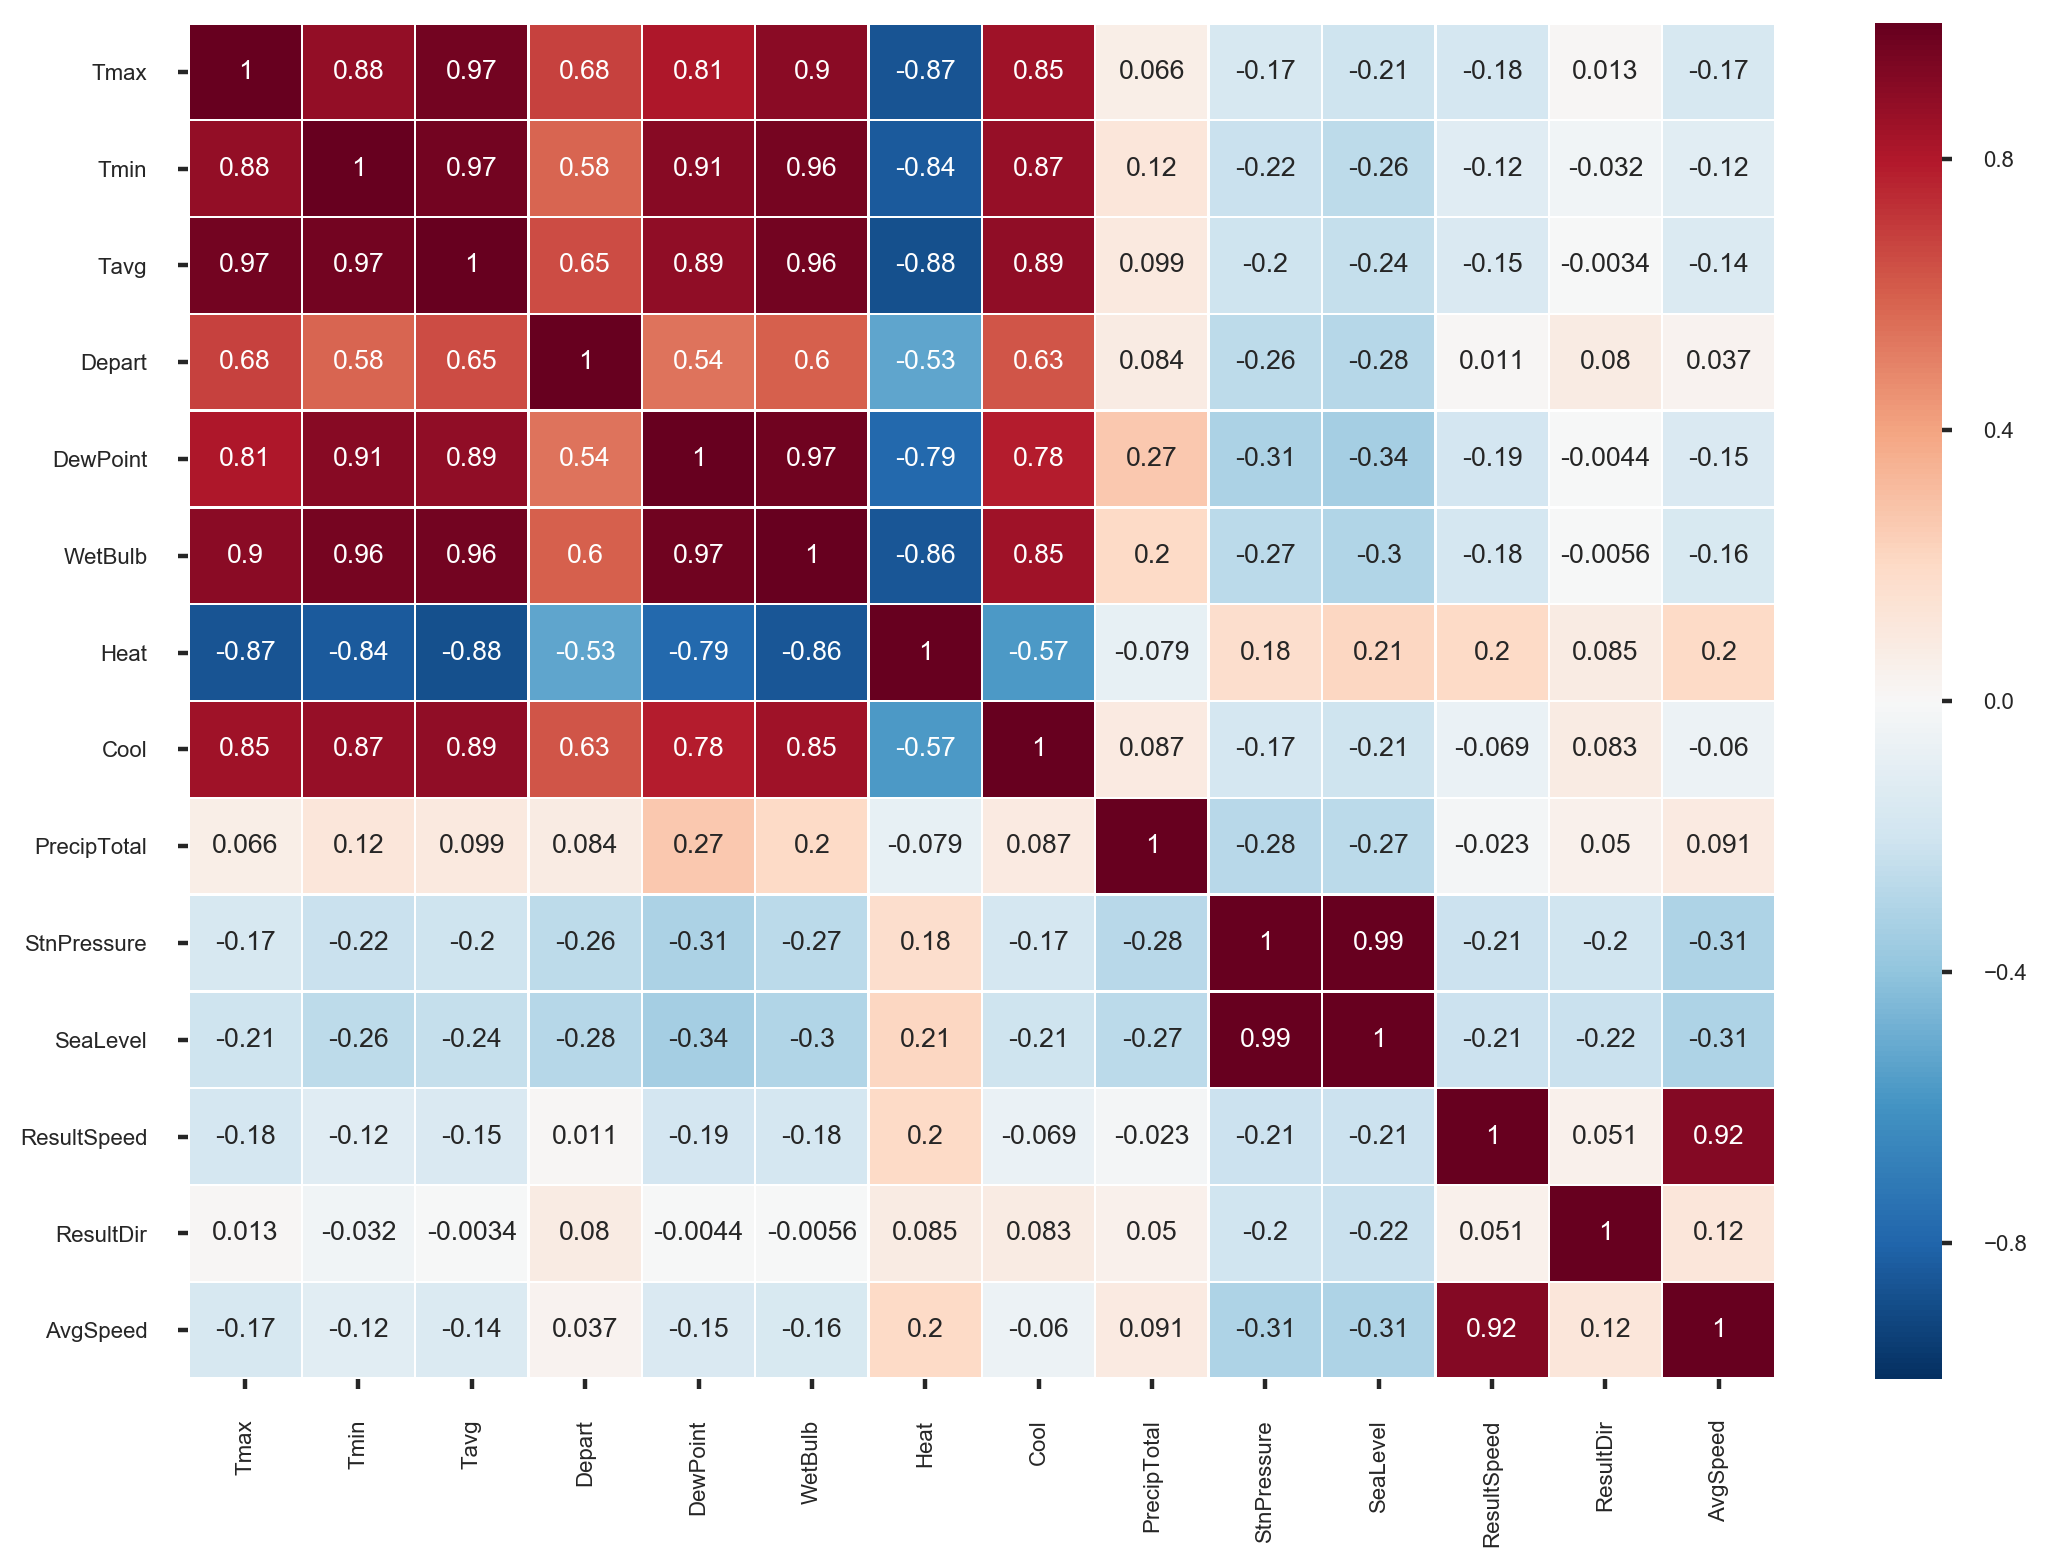

In [46]:
sns.heatmap(new_weather.corr(), annot=True, linewidth=0.5)
plt.xticks(rotation = 90)

## Building DF for Training

In [47]:
cdf = df_train[['Date', 'Species', 'Trap', 'WnvPresent', 'Latitude', 'Longitude']].merge(
      new_weather.drop(['Tmax', 'Tmin'], axis=1), left_on = 'Date', right_on = 'Date')

In [48]:
cdf.head(3)

,Date,Species,Trap,WnvPresent,Latitude,Longitude,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,0,41.954690,-87.800991,77.0,10.0,59.0,66.0,0.0,12.0,0421,1917,0.0,29.44,30.11,5.8,18.0,7.4
1,2007-05-29,CULEX RESTUANS,T002,0,41.954690,-87.800991,77.0,10.0,59.0,66.0,0.0,12.0,0421,1917,0.0,29.44,30.11,5.8,18.0,7.4
2,2007-05-29,CULEX RESTUANS,T007,0,41.994991,-87.769279,77.0,10.0,59.0,66.0,0.0,12.0,0421,1917,0.0,29.44,30.11,5.8,18.0,7.4


In [49]:
assert len(cdf) == len(df_train)

In [50]:
for i in df_train.Date.unique():
    if i not in cdf.Date.unique():
        print i

In [51]:
for i in df_test.Date.unique():
    if i not in new_weather.Date.unique():
        print i

In [52]:
cdf.describe(include=['object'])

,Date,Species,Trap,Sunrise,Sunset
count,9693,9693,9693,9693,9693
unique,95,7,136,62,58
top,2007-08-01,CULEX PIPIENS/RESTUANS,T900,0445,1931
freq,456,4469,612,628,630


In [53]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, normalize

In [54]:
traps = pd.concat([df_train.Trap, df_test.Trap], axis=0)
traps = list(set(traps))

In [55]:
le = LabelEncoder()
le.fit(traps)

LabelEncoder()

In [56]:
cdf['trap_encode'] = le.transform(cdf.Trap)

cdf.Date = pd.to_datetime(cdf.Date)
cdf['Month'] = cdf.Date.dt.month
cdf['Day'] = cdf.Date.dt.day

In [57]:
print df_train.Species.unique()
print
print df_test.Species.unique()

['CULEX PIPIENS/RESTUANS' 'CULEX RESTUANS' 'CULEX PIPIENS'
 'CULEX SALINARIUS' 'CULEX TERRITANS' 'CULEX TARSALIS' 'CULEX ERRATICUS']

['CULEX PIPIENS/RESTUANS' 'CULEX RESTUANS' 'CULEX PIPIENS'
 'CULEX SALINARIUS' 'CULEX TERRITANS' 'CULEX TARSALIS' 'UNSPECIFIED CULEX'
 'CULEX ERRATICUS']


In [58]:
species = pd.get_dummies(cdf.Species)

# Creating X and y variables

In [174]:
X = pd.concat([cdf.drop(['Date', 'Species', 'Trap', 'WnvPresent', 'Sunrise', 'Sunset'
                        ], axis=1), species], axis=1)

In [175]:
# X = X[red_cols]

In [176]:
ss = StandardScaler()
Xscaled = ss.fit_transform(X)

In [177]:
y = cdf['WnvPresent']

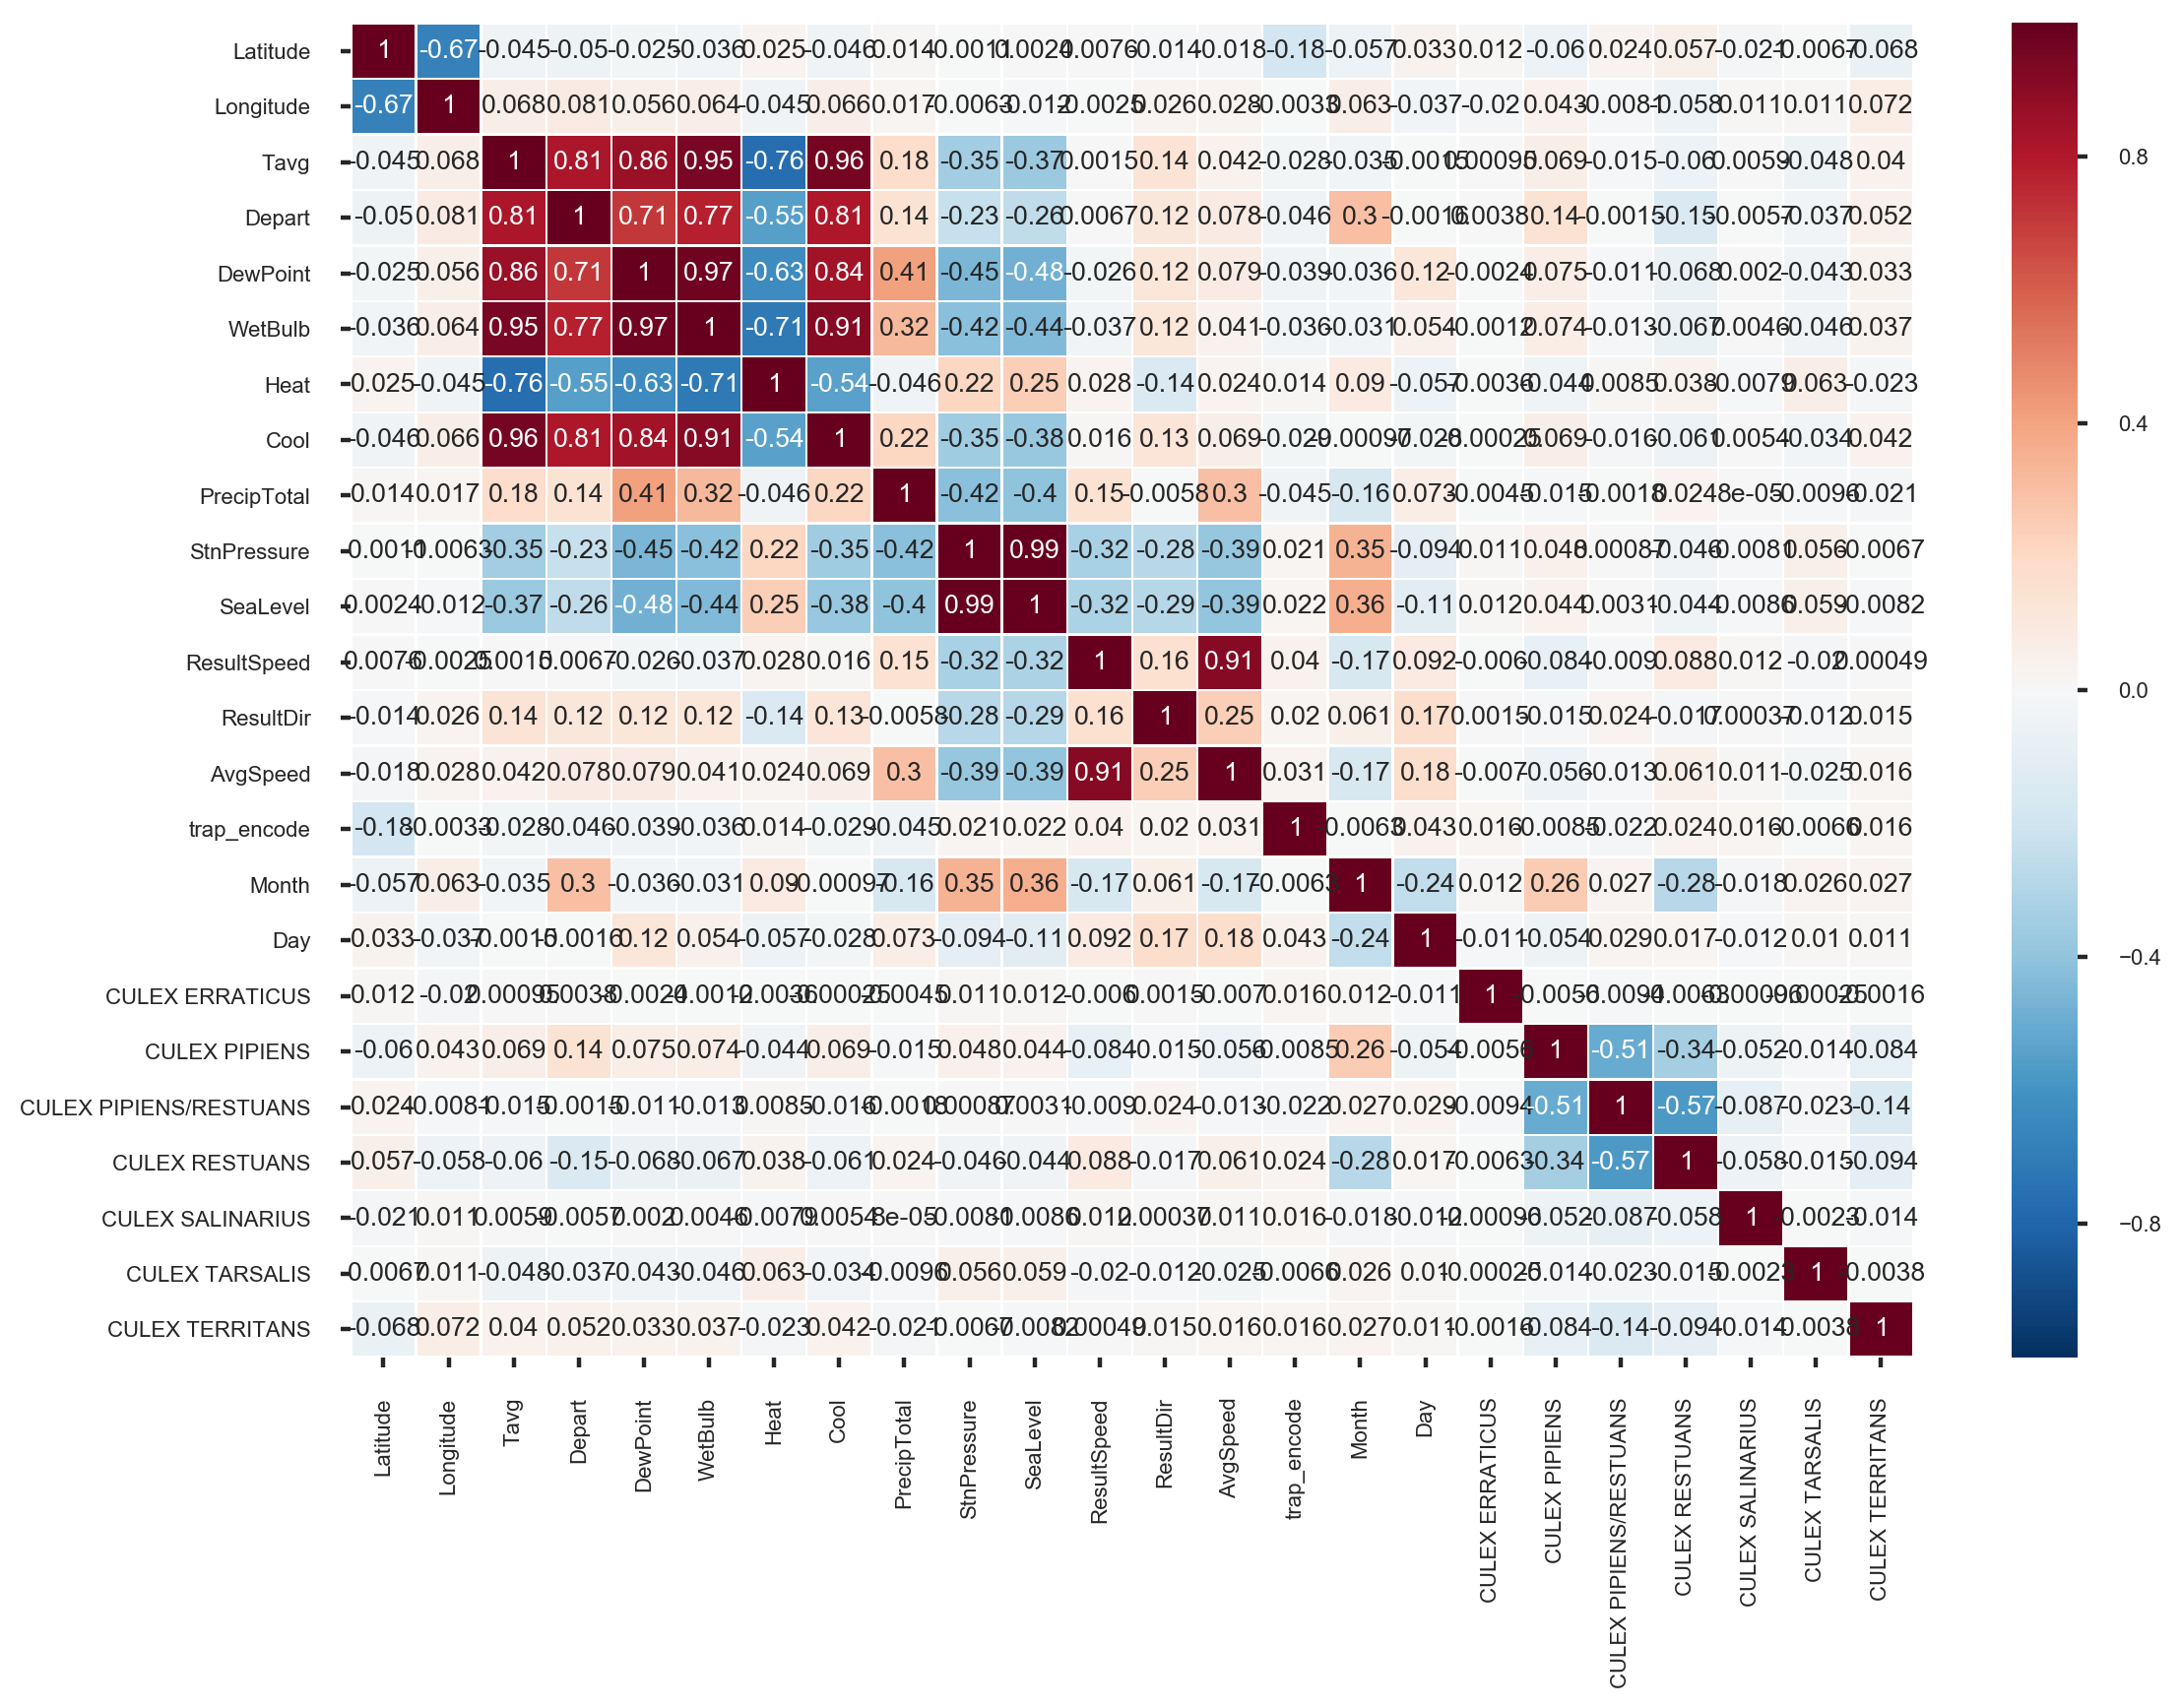

In [178]:
sns.heatmap(X.corr(), annot=True, linewidth=0.5)

# Building Models

In [179]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, stratify=y, test_size = 0.3, random_state=1)

In [64]:
from sklearn.model_selection import cross_val_score

In [65]:
def evaluate(model):
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    cm = np.array(confusion_matrix(y_test, pred, labels=[1,0]))
    names = ['WNV Present', 'Not Present', 'predicted yes', 'predicted no']
    confusion = pd.DataFrame(cm, index=names[:2], columns=names[2:])
    
    acc = accuracy_score(y_test, pred)
    print "Accuracy Score:", acc
    print
    print "Confusion Matrix:"
    print confusion
    print
    print "Classification Report:"
    print classification_report(y_test, pred)

In [66]:
def do_cv(model, crossval):
    s = cross_val_score(model, Xscaled, y, cv=crossval, n_jobs=-1, scoring='accuracy')
    print "Cross Validation Score: {:0.5} ± {:0.5}".format(s.mean().round(5), s.std().round(5))

In [124]:
def feat_imp(model):
    feature_importances = pd.DataFrame(model.feature_importances_, index = test_weather_df.columns).reset_index()
    feature_importances.columns = ['feature', 'importance']
    return feature_importances.sort_values('importance', ascending=False)

## Random Forest

In [180]:
rf = RandomForestClassifier(n_estimators=300)

In [181]:
evaluate(rf)

Accuracy Score: 0.940165061898

Confusion Matrix:
             predicted yes  predicted no
WNV Present             14           137
Not Present             37          2720

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2757
          1       0.27      0.09      0.14       151

avg / total       0.92      0.94      0.93      2908



In [70]:
do_cv(rf, 5)

Cross Validation Score: 0.71694 ± 0.27018


In [75]:
# try random forest with grid search

In [70]:
params = {
    'max_features':[0.5, "sqrt", "log2", None],
    'max_depth':[15, 20, 30, 50, None]
}

In [71]:
gs = GridSearchCV(rf, params, cv=10, n_jobs=-1)

In [72]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [0.5, 'sqrt', 'log2', None], 'max_depth': [15, 20, 30, 50, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [73]:
gs.best_params_

{'max_depth': 15, 'max_features': 'log2'}

In [ ]:
# adjust params and evaluate

In [138]:
rf = RandomForestClassifier(300, max_features=0.35, max_depth=15)

evaluate(rf)

Accuracy Score: 0.941196698762

Confusion Matrix:
             predicted yes  predicted no
WNV Present             15           136
Not Present             35          2722

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2757
          1       0.30      0.10      0.15       151

avg / total       0.92      0.94      0.93      2908



In [139]:
rf = RandomForestClassifier(300, max_features=0.75, max_depth=13)

evaluate(rf)

Accuracy Score: 0.943947730399

Confusion Matrix:
             predicted yes  predicted no
WNV Present             14           137
Not Present             26          2731

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2757
          1       0.35      0.09      0.15       151

avg / total       0.92      0.94      0.93      2908



## Gradient Boosting

In [140]:
gbc = GradientBoostingClassifier()
evaluate(gbc)

Accuracy Score: 0.944979367263

Confusion Matrix:
             predicted yes  predicted no
WNV Present              3           148
Not Present             12          2745

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2757
          1       0.20      0.02      0.04       151

avg / total       0.91      0.94      0.92      2908



In [74]:
# try finding best params with grid search

In [77]:
params = {
    'max_depth':[5, 8, 10, 15],
    'max_features':[None, "auto", 0.25, 0.5]
}

In [78]:
gs = GridSearchCV(gbc, params, cv=10, n_jobs=-1)

In [79]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'auto', 0.25, 0.5], 'max_depth': [5, 8, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [80]:
gs.best_score_

0.94576271186440675

In [81]:
gs.best_params_

{'max_depth': 5, 'max_features': 0.25}

In [75]:
# adjust params and evaluate

In [141]:
gbc = GradientBoostingClassifier(max_depth=6, max_features=0.75)
evaluate(gbc)

Accuracy Score: 0.943603851444

Confusion Matrix:
             predicted yes  predicted no
WNV Present             17           134
Not Present             30          2727

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2757
          1       0.36      0.11      0.17       151

avg / total       0.92      0.94      0.93      2908



# Building DF for Testing

In [182]:
test_weather_df = df_test.merge(new_weather, left_on = 'Date', right_on = 'Date')

test_weather_df['trap_encode'] = le.transform(test_weather_df.Trap)

test_weather_df.Date = pd.to_datetime(test_weather_df.Date)
test_weather_df['Month'] = test_weather_df.Date.dt.month
test_weather_df['Day'] = test_weather_df.Date.dt.day

In [183]:
test_species_dummies = pd.get_dummies(test_weather_df.Species).drop('UNSPECIFIED CULEX', axis=1)

In [184]:
test_weather_df = pd.concat([test_weather_df, test_species_dummies], axis=1)
test_weather_df.drop(['Date', 'Species', 'Trap'], axis=1, inplace=True)

In [185]:
test_weather_df = test_weather_df[X.columns]

In [186]:
assert len(test_weather_df.columns) == len(X.columns)

# Making Predictions

In [201]:
rf = RandomForestClassifier(500, max_features=0.75, max_depth=15)

evaluate(rf)

Accuracy Score: 0.940165061898

Confusion Matrix:
             predicted yes  predicted no
WNV Present             17           134
Not Present             40          2717

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2757
          1       0.30      0.11      0.16       151

avg / total       0.92      0.94      0.93      2908



In [199]:
feat_imp(rf)

,feature,importance
1,Longitude,0.169466
0,Latitude,0.167352
14,trap_encode,0.162504
12,ResultDir,0.052998
18,CULEX PIPIENS,0.049773
19,CULEX PIPIENS/RESTUANS,0.049176
16,Day,0.034750
15,Month,0.033458
20,CULEX RESTUANS,0.030607
4,DewPoint,0.029463


In [202]:
do_cv(rf, 8)

Cross Validation Score: 0.58387 ± 0.2959


In [203]:
test_scaled = StandardScaler().fit_transform(test_weather_df)

rf.fit(Xscaled, y)

preds = rf.predict_proba(test_scaled)
pred_prob = [round(i[1],1) for i in preds]

assert len(pred_prob) == len(df_test)

submission = pd.DataFrame(columns=['Id', 'WnvPresent'])
submission.Id = df_test.Id
# submission.drop('WnvPresent', inplace=True)

assert len(submission) == len(df_test)

submission['WnvPresent'] = pred_prob

In [204]:
submission.tail()

,Id,WnvPresent
116288,116289,0.0
116289,116290,0.0
116290,116291,0.0
116291,116292,0.0
116292,116293,0.0


In [205]:
submission.to_csv('submission4.csv', index=False)

In [206]:
submission['Latitude'] = df_test.Latitude
submission['Longitude'] = df_test.Longitude
submission['WNV_binary'] = rf.predict(test_scaled)

In [207]:
submission.tail()

,Id,WnvPresent,Latitude,Longitude,WNV_binary
116288,116289,0.0,41.925652,-87.63359,0
116289,116290,0.0,41.925652,-87.63359,0
116290,116291,0.0,41.925652,-87.63359,0
116291,116292,0.0,41.925652,-87.63359,0
116292,116293,0.0,41.925652,-87.63359,0


In [208]:
submission.to_csv('final_submission.csv', index=False)

# PCA

In [159]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [160]:
cov_mat = pd.DataFrame(Xscaled, columns=X.columns).corr()
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
value_vector_pairs = [[eig_vals[i], eig_vecs[:,i]] for i in range(len(eig_vals))]
value_vector_pairs.sort(reverse=True)

In [161]:
EVSum = sum(eig_vals)
# EV = eigenvalue divided by the sum of all eigenvalues times 100
var_exp = [(i / EVSum)*100 for i in sorted(eig_vals, reverse=True)]

cum_var_exp = np.cumsum(var_exp)
print cum_var_exp

[  21.31143021   37.29519994   51.39703368   63.63757233   72.42108892
   80.45552145   87.30480933   91.88797997   95.82485672   98.33173089
   99.41680765  100.        ]


In [162]:
pca = PCA(n_components=12)
skl_pca = pca.fit_transform(Xscaled)

In [163]:
len(skl_pca)

9693

## PCA Models

In [164]:
Xpca_train, Xpca_test, ypca_train, ypca_test = train_test_split(skl_pca, y, test_size=0.3, random_state=20)

In [165]:
def evaluate_pca(model):
    model.fit(Xpca_train, ypca_train)
    
    pred = model.predict(Xpca_test)
    
    cm = np.array(confusion_matrix(ypca_test, pred, labels=[1,0]))
    names = ['WNV Present', 'Not Present', 'predicted yes', 'predicted no']
    confusion = pd.DataFrame(cm, index=names[:2], columns=names[2:])
    
    acc = accuracy_score(ypca_test, pred)
    print "Accuracy Score:", acc
    print
    print "Confusion Matrix:"
    print confusion
    print
    print "Classification Report:"
    print classification_report(ypca_test, pred)

In [113]:
lr = LogisticRegression()
evaluate_pca(lr)

Accuracy Score: 0.949105914718

Confusion Matrix:
             predicted yes  predicted no
WNV Present              0           148
Not Present              0          2760

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2760
          1       0.00      0.00      0.00       148

avg / total       0.90      0.95      0.92      2908



In [170]:
rf = RandomForestClassifier(n_estimators=500, max_depth=30, max_features=0.5)
# rf.fit(Xpca_train, ypca_train)

In [171]:
evaluate_pca(rf)

Accuracy Score: 0.943603851444

Confusion Matrix:
             predicted yes  predicted no
WNV Present             17           131
Not Present             33          2727

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2760
          1       0.34      0.11      0.17       148

avg / total       0.92      0.94      0.93      2908

